In [1]:
import numpy as np
import spotpy
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
import sys
import copy
import datetime as dt

import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt

import pcse
from pcse.models import Wofost72_WLP_FD
print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

This notebook was built with:
python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
PCSE version: 5.5.6


In [6]:
from dataproviders import parameters, agromanagement, weather
wofost = Wofost72_WLP_FD(parameters, weather, agromanagement)
wofost.run_till_terminate()
df = pd.DataFrame(wofost.get_output()).set_index("day")

In [7]:
variables_for_DA = ["LAI", "SM"]
dates_of_observation = [dt.date(2000,2,7), dt.date(2000,2,28), dt.date(2000,3,20), 
                        dt.date(2000,4,10), dt.date(2000,5,1)]
observed_lai = np.array([2.2, 3.5, 6.2, 3.3, 2.1])
std_lai = observed_lai * 0.1 # Std. devation is estimated as 10% of observed value                                                                 
observed_sm = np.array([0.285, 0.26, 0.28, 0.18, 0.17])
std_sm = observed_sm * 0.05 # Std. devation is estimated as 5% of observed value
observations_for_DA = []
# Pack them into a convenient format
observations_for_DA = [(d, {"LAI": (lai, errlai), "SM": (sm, errsm)}) for d, lai, errlai, sm, errsm in zip(dates_of_observation, observed_lai, std_lai, observed_sm, std_sm)]

In [5]:
observations_for_DA

[(datetime.date(2000, 2, 7),
  {'LAI': (2.2, 0.22000000000000003), 'SM': (0.285, 0.014249999999999999)}),
 (datetime.date(2000, 2, 28),
  {'LAI': (3.5, 0.35000000000000003), 'SM': (0.26, 0.013000000000000001)}),
 (datetime.date(2000, 3, 20),
  {'LAI': (6.2, 0.6200000000000001), 'SM': (0.28, 0.014000000000000002)}),
 (datetime.date(2000, 4, 10), {'LAI': (3.3, 0.33), 'SM': (0.18, 0.009)}),
 (datetime.date(2000, 5, 1),
  {'LAI': (2.1, 0.21000000000000002), 'SM': (0.17, 0.0085)})]

In [46]:
df[df.index == dt.date(2000,1,7)]['LAI']

day
2000-01-07    0.210168
Name: LAI, dtype: float64

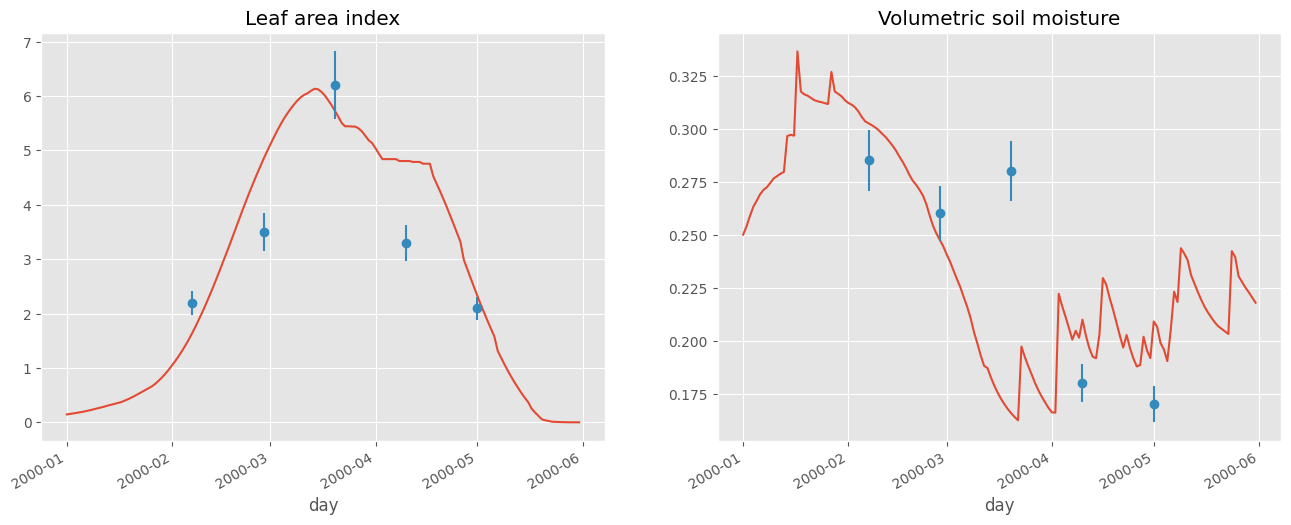

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
df["LAI"].plot(ax=axes[0], label="leaf area index")
axes[0].errorbar(dates_of_observation, observed_lai, yerr=std_lai, fmt="o")
df["SM"].plot(ax=axes[1], label="rootzone soil moisture")
axes[1].errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o")
axes[0].set_title("Leaf area index")
axes[1].set_title("Volumetric soil moisture")
fig.autofmt_xdate()

In [11]:
print('== Current parameters ==')
print('TDWI', parameters['TDWI'])
print('WAV', parameters['WAV'])
print('SPAN', parameters['SPAN'])
print('SMFCF', parameters['SMFCF'])

== Current parameters ==
TDWI 210.0
WAV 10.0
SPAN 31.3
SMFCF 0.3175


In [129]:
"""
Copyright 2015 by Tobias Houska
This file is part of Statistical Parameter Estimation Tool (SPOTPY).

:author: Tobias Houska

This example implements the python version of hymod into SPOTPY.
"""


import os

from spotpy.examples.hymod_python.hymod import hymod
from spotpy.objectivefunctions import rmse
from spotpy.parameter import Uniform, Normal


class spot_setup(object):

    param_tdwi = Normal(mean=150., stddev=50.)
    param_wav = Normal(mean=4.5, stddev=1.5)
    param_span = Normal(mean=31., stddev=3.)
    param_smfcf = Normal(mean=0.31, stddev=0.03)

    def __init__(self,obj_func=None):
        print('Init...')

        self.variables_for_DA = ["LAI", "SM"]
        self.dates_of_observation = [dt.date(2000,2,7), dt.date(2000,2,28), dt.date(2000,3,20), 
                                dt.date(2000,4,10), dt.date(2000,5,1)]
        self.observed_lai = np.array([2.2, 3.5, 6.2, 3.3, 2.1])
        self.std_lai = self.observed_lai * 0.1 # Std. devation is estimated as 10% of observed value                                                                 
        self.observed_sm = np.array([0.285, 0.26, 0.28, 0.18, 0.17])
        self.std_sm = self.observed_sm * 0.05 # Std. devation is estimated as 5% of observed value
        self.observations_for_DA = []
        # Pack them into a convenient format
        self.observations_for_DA = [(d, {"LAI": (lai, errlai), "SM": (sm, errsm)}) for d, lai, errlai, sm, errsm in zip(self.dates_of_observation, self.observed_lai, self.std_lai, self.observed_sm, self.std_sm)]

        self.cov_matrix = np.zeros((len(self.dates_of_observation), 2, 2))
        self.cov_matrix[:, 0, 0] = self.std_lai ** 2
        self.cov_matrix[:, 1, 1] = self.std_sm ** 2

        print("Init Done")

    def simulation(self, x):
        """
        x : paramètres (tableau)

        Cette fonction doit retourner un tableau contenant les données prédites par le modèle, pour les paramètres données
        """
        print('Simulation...')
        tdwi = x[0]
        wav = x[1]
        span = x[2]
        smfcf = x[3]

        p = copy.deepcopy(parameters)
        p.set_override("TDWI", tdwi)
        p.set_override("WAV", wav)
        p.set_override("SPAN", span)
        p.set_override("SMFCF", smfcf)

        member = Wofost72_WLP_FD(p, weather, agromanagement)

        member.run_till_terminate()
        df = pd.DataFrame(member.get_output()).set_index("day")

        corrected_lai = np.zeros((len(self.dates_of_observation)))
        corrected_sm = np.zeros((len(self.dates_of_observation)))

        for i, eval_date in enumerate(self.dates_of_observation):

            corrected_lai[i] = df[df.index == eval_date]['LAI'][0]
            corrected_sm[i] = df[df.index == eval_date]['SM'][0]

        corrected_state = np.stack([corrected_lai, corrected_sm])

        #print("Simulation done")
        return corrected_state

    def evaluation(self):        
        """
        Cette fonction doit donner les variables observés
        """

        observed_lai = np.zeros((len(self.dates_of_observation)))
        observed_sm = np.zeros((len(self.dates_of_observation)))


        for i, eval_date in enumerate(self.dates_of_observation):
            #print(i, eval_date)

            eval_infos = self.observations_for_DA[i][1]
            observed_lai[i] = eval_infos['LAI'][0]
            observed_sm[i] = eval_infos['SM'][0]

        observed_state = np.stack([observed_lai, observed_sm])

        #print("Evaluation done")
        return observed_state


    def cost_function(self, estimated_state, observed_state, cov_matrix):
        J = 0
        for i in range(estimated_state.shape[1]):
            J += 1/2 * (observed_state[:, i]-estimated_state[:, i]).T @ \
                np.linalg.inv(
                    cov_matrix[i]) @ (observed_state[:, i]-estimated_state[:, i])
        #print('Cost done')
        return J

    def objectivefunction(self, simulation, evaluation, params=None):
        """
        Simulation : tableau contenant les données simulées
        Evaluation : tableau contenant les variables observés
        """

        #print("Simulation", simulation)
        #print("Evaluation", evaluation)

        #print('Objective...')
        
        corrected_J = self.cost_function(simulation, evaluation, self.cov_matrix)

        print('J', corrected_J)
        return corrected_J

In [130]:
spot_setup=spot_setup()

Init...
Init Done


In [131]:
sampler=spotpy.algorithms.sceua(spot_setup, dbname='test_4dvar', dbformat='csv')

In [132]:
rep=250
sampler.sample(rep, ngs=7, kstop=3, peps=0.1, pcento=0.1)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  250  repetitions
The objective function will be minimized
Starting burn-in sampling...
Simulation...
J 159.62461129023467
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'test_4dvar.csv' created.
Simulation...
J 167.1065354106556
2 of 250, minimal objective function=159.625, time remaining: 00:03:10
Simulation...
J 188.85061517540186
Simulation...
J 147.09349244058467
4 of 250, minimal objective function=147.093, time remaining: 00:03:34
Simulation...
J 70.42192415970258
Simulation...
J 74.30248682668542
6 of 250, minimal objective function=70.4219, time remaining: 00:03:42
Simulation...
J 134.28900032889047
Simulation...
J 98.47871861538097
Simulation...
J 91.92344462421411
9 of 250, minimal objective function=70.4219, time remaining: 00:03:28
Simulation...
J 96.09894807885773
Simulation...
J 116.12203539829655
Simulation...
J 112.01449848629257
12 of 250, minimal objective 

In [114]:
from dataproviders import parameters, agromanagement, weather

p = copy.deepcopy(parameters)
p.set_override("TDWI", 197.646)
p.set_override("WAV", 6.41972)
p.set_override("SPAN", 31.6648)
p.set_override("SMFCF", 0.280681)

wofost_optimal = Wofost72_WLP_FD(p, weather, agromanagement)
wofost_optimal.run_till_terminate()
df_optimal = pd.DataFrame(wofost_optimal.get_output()).set_index("day")

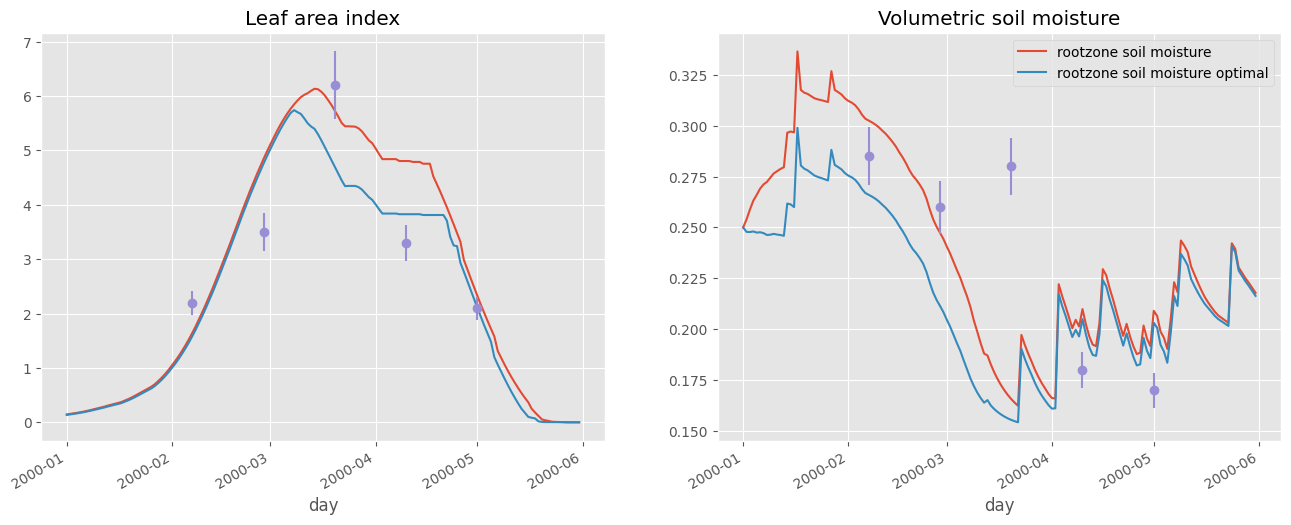

In [117]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
df["LAI"].plot(ax=axes[0], label="leaf area index")
df_optimal["LAI"].plot(ax=axes[0], label="leaf area index optimal")
axes[0].errorbar(dates_of_observation, observed_lai, yerr=std_lai, fmt="o")
df["SM"].plot(ax=axes[1], label="rootzone soil moisture")
df_optimal["SM"].plot(ax=axes[1], label="rootzone soil moisture optimal")
axes[1].errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o")
axes[0].set_title("Leaf area index")
axes[1].set_title("Volumetric soil moisture")
fig.autofmt_xdate()
plt.legend()

In [109]:
results = spotpy.analyser.load_csv_results('test_4dvar')

/home/erwin/.local/lib/python3.10/site-packages/spotpy/analyser.py:31: ConversionWarning: Some errors were detected !
    Line #2 (got 8 columns instead of 16)
    Line #3 (got 8 columns instead of 16)
    Line #4 (got 8 columns instead of 16)
    Line #5 (got 8 columns instead of 16)
    Line #6 (got 8 columns instead of 16)
    Line #7 (got 8 columns instead of 16)
    Line #8 (got 8 columns instead of 16)
    Line #9 (got 8 columns instead of 16)
    Line #10 (got 8 columns instead of 16)
    Line #11 (got 8 columns instead of 16)
    Line #12 (got 8 columns instead of 16)
    Line #13 (got 8 columns instead of 16)
    Line #14 (got 8 columns instead of 16)
    Line #15 (got 8 columns instead of 16)
    Line #16 (got 8 columns instead of 16)
    Line #17 (got 8 columns instead of 16)
    Line #18 (got 8 columns instead of 16)
    Line #19 (got 8 columns instead of 16)
    Line #20 (got 8 columns instead of 16)
    Line #21 (got 8 columns instead of 16)
    Line #22 (got 8 columns in

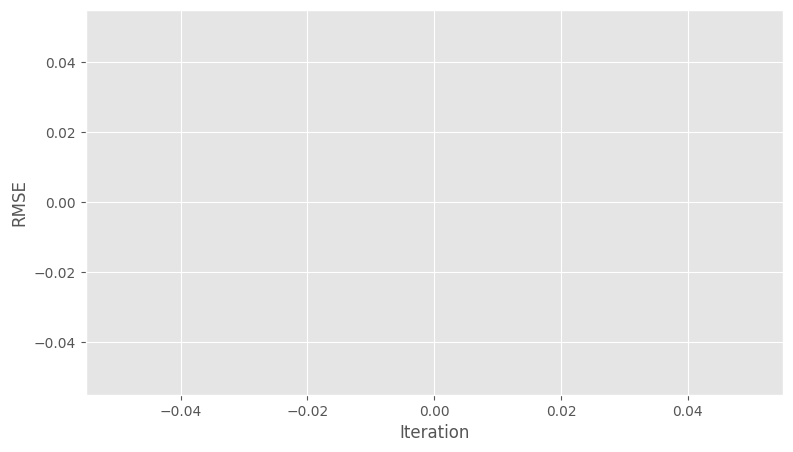

In [110]:
fig= plt.figure(1,figsize=(9,5))
plt.plot(results['like1'])
plt.ylabel('RMSE')
plt.xlabel('Iteration')
fig.savefig('SCEUA_objectivefunctiontrace.png',dpi=300)

plt.show()

In [50]:
bestindex,bestobjf = spotpy.analyser.get_minlikeindex(results)

Run number 133 has the lowest objectivefunction with: 0.0003


In [51]:
best_model_run = results[bestindex]

In [52]:
fields=[word for word in best_model_run.dtype.names if word.startswith('sim')]
best_simulation = list(best_model_run[fields])

NameError: name 'best_simulation' is not defined

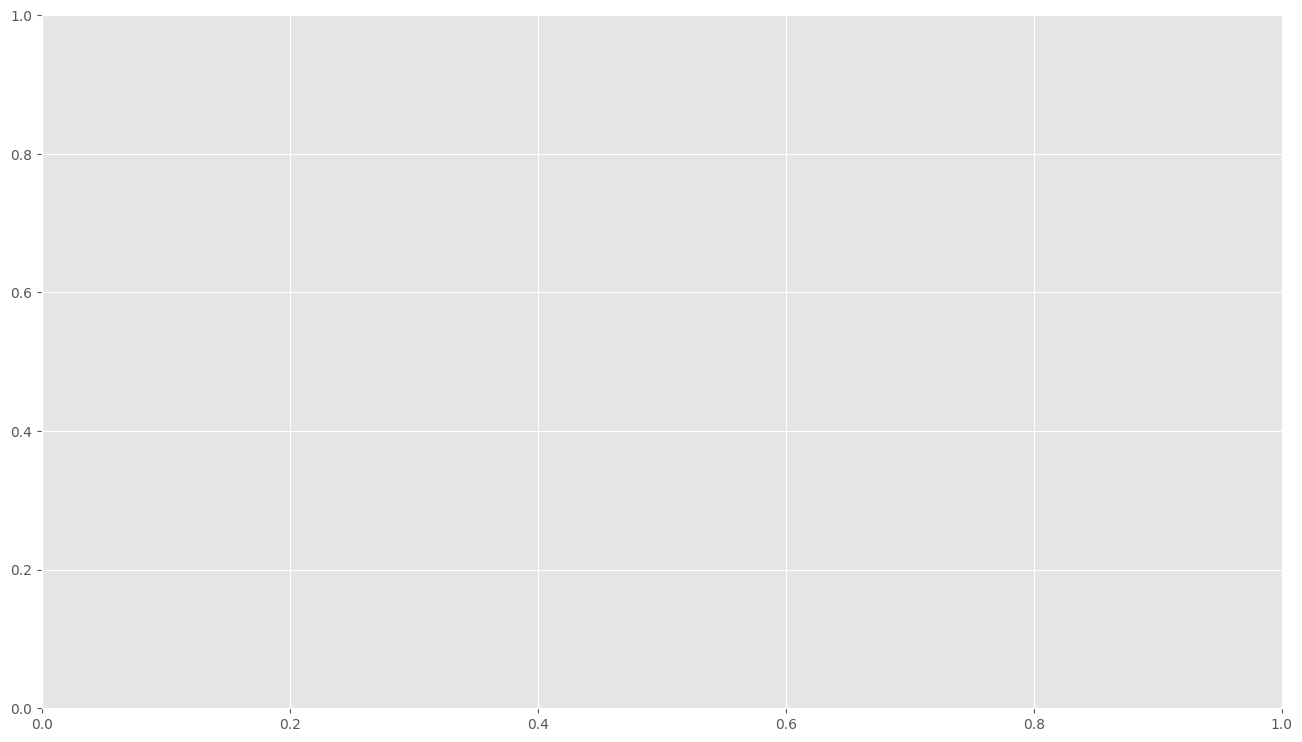

In [111]:
fig= plt.figure(figsize=(16,9))
ax = plt.subplot(1,1,1)
ax.plot(best_simulation,color='black',linestyle='solid', label='Best objf.='+str(bestobjf))
ax.plot(spot_setup.evaluation(),'r.',markersize=3, label='Observation data')
plt.xlabel('Number of Observation Points')
plt.ylabel ('Discharge [l s-1]')
plt.legend(loc='upper right')
fig.savefig('SCEUA_best_modelrun.png',dpi=300)